# Arbitrary precision rational Remez

## Prelude

In [1]:
#!pip install matplotlib ipympl numpy mpmath watermark

In [2]:
%matplotlib widget

import itertools
import math

import matplotlib
import numpy as np
from mpmath import mp
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual

In [3]:
# Defaults more suitable for 4K monitors
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.figsize"] = [6.0, 4.0]
# Change font to match Latex
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'CMU Serif'
# Export settings
mpl.rcParams["savefig.bbox"] = 'tight'
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.facecolor"] = 'white'
# High compression lossless WebP for animations using ffmpeg -> libwebp
mpl.rcParams["animation.writer"] = 'ffmpeg'
mpl.rcParams["animation.codec"] = 'webp'
mpl.rcParams["animation.ffmpeg_args"] = ["-lossless", "1", "-qscale", "100"]
# Use anim.save("movie.webp", fps=60)

In [4]:
# Use a thousand bits of precision in mp
mp.prec = 1000

In [5]:
import watermark.watermark as watermark
print(watermark(machine=True, iso8601=True, python=True, iversions=True, globals_=globals()))

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

Compiler    : Clang 13.1.6 (clang-1316.0.21.2)
OS          : Darwin
Release     : 21.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

numpy     : 1.22.3
matplotlib: 3.5.1



## Target

In [6]:
def f(x):
    return mp.log(x)

start = 1
stop = 2

In [7]:
(start, stop)

(1, 2)

In [8]:
f(start), f(stop)

(mpf('0.0'),
 mpf('0.693147180559945309417232121458176568075500134360255254120680009493393621969694715605863326996418687542001481020570685733685520235758130557032670751635075961930727570828371435190307038623891673471123350115364497955239120475172681574932065155524734139525882950453007095326366642654104239157814952043740407'))

## Utils

In [9]:
def linspace(start, stop, n):
    return [start + (stop - start) * mp.mpf(i) / (n - 1) for i in range(n)]

In [199]:
def argmax(seq):
    return max(range(len(seq)), key=seq.__getitem__)

In [198]:
def golden_section_search(f, a, b, **kwargs):
    '''Minimizes f on the [a, b] interval'''
    c = b - (b - a) / mp.phi
    d = a + (b - a) / mp.phi
    while not mp.almosteq(a, b, **kwargs):
        if f(c) < f(d):
            b = d
        else:
            a = c
        c = b - (b - a) / mp.phi
        d = a + (b - a) / mp.phi
    return (b + a) / 2

In [245]:
def max_error(h, N = 1000):
    def err(x):
        return abs(h(x) - f(x))
    
    # Grid search
    x = linspace(start, stop, N)
    e = [err(x) for x in x]
    i = argmax(e)
    
    # Refine
    a = x[i - 1] if i > 0 else start
    b = x[i + 1] if i < len(x) - 1 else stop
    xm = golden_section_search(lambda x: -err(x), a, b, abs_eps=0.000000001)
    
    return err(xm)

In [273]:
def plot(h):
    x = linspace(start, stop, 1000)
    yf = [f(x) for x in x]
    yh = [h(x) for x in x]
    
    e = [yh - yf for yh, yf in zip(yh, yf)]
    em = max_error(h)
    print(f'Maximum absolute error: {float(em)}')
    
    fig = plt.figure()
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212, sharex = ax1)

    ax1.set_title('Function approximation')
    ax1.plot(x, yf, color='blue', label='truth')
    ax1.plot(x, yh, color='orange', label='approximation')
    ax1.legend()
    
    ax2.set_title('Approximation error')
    ax2.plot(x, e, color='red', label='error')
    ax2.axhline(0, color='black', linestyle='solid')
    ax2.axhline(-em, color='red', linestyle='dashed')
    ax2.axhline(em, color='red', linestyle='dashed')

In [276]:
def plot_roots(p, q):
    fig = plt.figure()
    ax = plt.subplot(111)
    
    roots = mp.polyroots(list(reversed(p)), extraprec=200)
    ax.scatter([root.real for root in roots], [root.imag for root in roots], color='blue', marker='+')
    
    roots = mp.polyroots(list(reversed(q)), extraprec=200)
    ax.scatter([root.real for root in roots], [root.imag for root in roots], color='red', marker='x')
    
    ax.set_xlim([0,3])

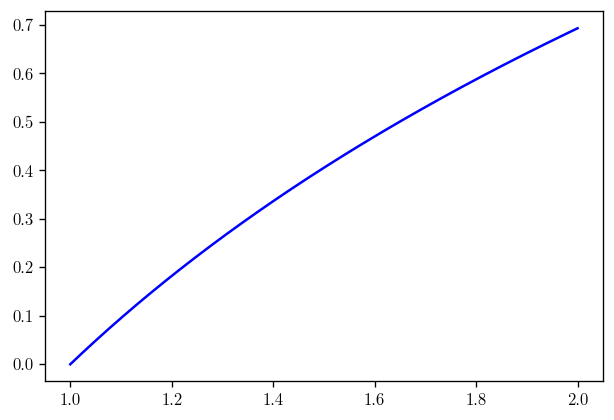

In [13]:
plt.plot(linspace(start, stop, 1000), [f(x) for x in linspace(start, stop, 1000)], color='blue', label='truth')

## Chebyshev

In [14]:
def chebyshev_nodes(start, stop, n):
    x = []
    c = (start + stop) / 2
    s = (stop - start) / 2
    for i in range(n):
        f = (2 * mp.mpf(i) + 1 ) / (2 * n)
        x.append(c - s * mp.cos(f * mp.pi))
    return x

In [15]:
def ratfn(p ,q):
    pr = list(reversed(p))
    qr = list(reversed(q))
    def h(x):
        return mp.polyval(pr, x) / mp.polyval(qr, x)
    return h

In [16]:
def rat_fit(n, m, x, y, check_poles=True):
    global f, start, stop
    M = mp.matrix(n + m - 1)
    for i in range(M.rows):
        for j in range(n):
            M[i, j] = x[i] ** j
        for j in range(m - 1):
            M[i, j + n] = - y[i] * x[i] ** (j + 1)
    r = list(mp.lu_solve(M, y))
    p, q = r[:n], [mp.mpf(1)] + r[n:]
    
    # Make sure q has no roots in the domain
    if check_poles:
        for root in mp.polyroots(list(reversed(q))):
            # Real roots in the domain
            if type(root) == mp.mpf and root >= start and root <= stop:
                raise ZeroDivisionError("Zeros in denominator")
    
    return (p, q, ratfn(p, q))

In [27]:
def rational(n, m, **kwargs):
    global f, start, stop
    x = chebyshev_nodes(start, stop, n + m - 1)
    y = [f(x) for x in x]
    return rat_fit(n, m, x, y, **kwargs)

## Manual

In [28]:
# Use medium precision to find the number of coefficients
mp.prec = 256
num_parameters = 13

for num_parameters in range(3, 20):
    for j in range(num_parameters):
        n = num_parameters - j
        m = 1 + num_parameters - n
        p, q, h = rational(n, m, check_poles=False)
        print(f'{num_parameters} ({n}, {m}) max error: {float(max_error(h))}')

3 (3, 1) max error: 0.004168304156929293
3 (2, 2) max error: 0.0009837778088915131
3 (1, 3) max error: 129.7730726092178
4 (4, 1) max error: 0.0006191035544048819
4 (3, 2) max error: 5.8435752960971383e-05
4 (2, 3) max error: 8.298467032586489e-05
4 (1, 4) max error: 59.474141206017336
5 (5, 1) max error: 9.8805520124879e-05
5 (4, 2) max error: 4.650036942218403e-06
5 (3, 3) max error: 2.1720202218353656e-06
5 (2, 4) max error: 9.179228572123224e-06
5 (1, 5) max error: 27.609818717620307
6 (6, 1) max error: 1.6492039716689736e-05
6 (5, 2) max error: 4.5228530416833366e-07
6 (4, 3) max error: 1.1350481861691371e-07
6 (3, 4) max error: 1.3585623428021178e-07
6 (2, 5) max error: 1.1975953993811078e-06
6 (1, 6) max error: 22.405607409143695
7 (7, 1) max error: 2.8383786595024693e-06
7 (6, 2) max error: 4.9354955419932495e-08
7 (5, 3) max error: 7.905994787821191e-09
7 (4, 4) max error: 4.56663411507637e-09
7 (3, 5) max error: 1.1160513994922265e-08
7 (2, 6) max error: 1.7457470943096297e-0

Maximum absolute error: 8.399070536193643e-20


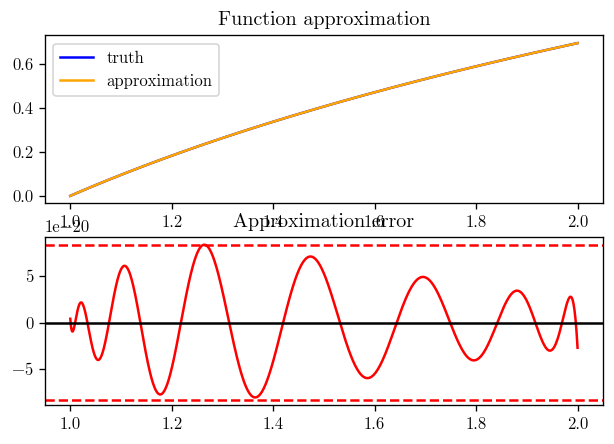

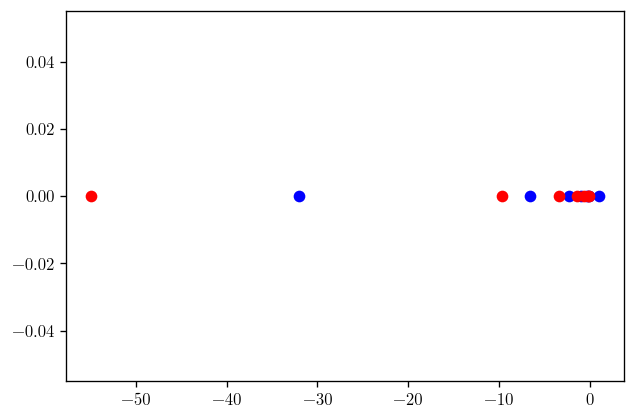

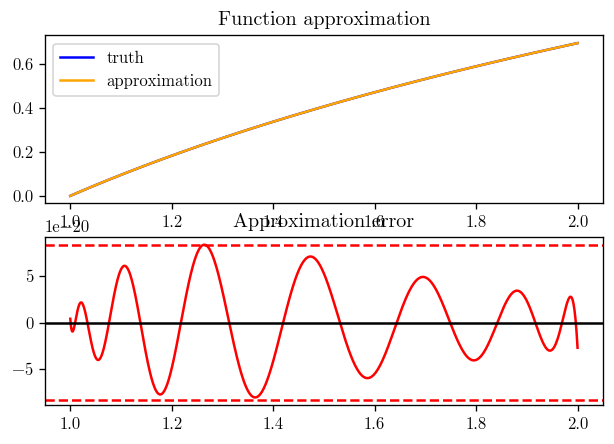

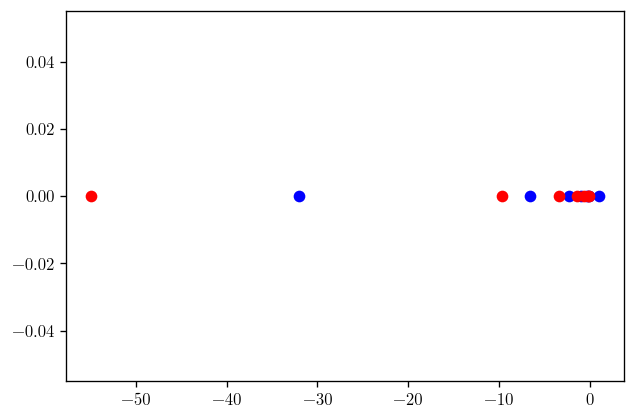

In [47]:
plt.close('all')

x = chebyshev_nodes(start, stop, 15)
x = [1 + (x - 1)**mp.mpf('1.253') for x in x]
y = [f(x) for x in x]

p, q, h = rat_fit(8, 8, x, y)
plot(h)
plot_roots(p, q)

In [255]:
mp.prec = 128

x = chebyshev_nodes(start, stop, 15)
x = [1 + (x - 1)**mp.mpf('1.253') for x in x]
y = [f(x) for x in x]

p, q, h = rat_fit(8, 8, x, y)
me = max_error(h)

def wiggle(i, xi):
    global f, x, y, p, q, h, me
    xl = x.copy()
    yl = y.copy()
    xl[i] = xi
    yl[i] = f(xi)
    
    p, q, h = rat_fit(8, 8, xl, yl, check_poles=False)
    me = max_error(h)
    return me

In [267]:
from mpmath import mpf

x = [mpf('1.002086509792016565270393850245050414330808808987712901699064018884396061650252'),
 mpf('1.019152199809059631651197854534135282024305767025984601211834795399356287670731'),
 mpf('1.044709564539441764320766365217672835099530883034777140251970225352442422145264'),
 mpf('1.093720279287117355572600107054799012326423167092957069219135936568777874263096'),
 mpf('1.155988349218054563342016547050521864153864815097449058429411867760516041393505'),
 mpf('1.230257940600440961064919022464803513761844429032006232910028016750521452902459'),
 mpf('1.317167099785201980562999508653270877959222413691730764501031374826767456888606'),
 mpf('1.420283231792458138245747499430821583228244186079926191362583940046443620108262'),
 mpf('1.52701591906390595568585228540637529256430318067944240114866956864463950054253'),
 mpf('1.645777437241906260833921744455990649022976673068140782514525900529784104472073'),
 mpf('1.745719216095053480687368461080827650448002097649485392950785732881575124818569'),
 mpf('1.852643072692638769046920471946494076663675479312691430710740786207621133965367'),
 mpf('1.886306292274304365673031574063938376245015241921829296026580719225397837305075'),
 mpf('1.96634895931940552236478298947382491304910438883790798643619356584248447740209'),
 mpf('1.994901335188944799369815888239399301282906579527004811820993327972277098357374')]

In [263]:
def optiaxis(i):
    global f, start, stop, x, y
    if i > 0:
        a = (99999999 * x[i - 1] + x[i]) / 100000000
    else:
        a = start
    if i < len(x) - 1:
        b = (99999999 * x[i + 1] + x[i]) / 100000000
    else:
        b = stop

    xi = golden_section_search(lambda xi: wiggle(i, xi), a, b, abs_eps=0.00000001)
    
    x[i] = xi
    y[i] = f(x[i])

In [264]:
mp.prec = 256
x = [mp.mpf(x) for x in x]
y = [f(x) for x in x]

In [265]:
while True:
    rng = np.random.default_rng()
    for i in rng.permutation(15):
        optiaxis(i)
        print(f'{i}: {float(me)}')

11: 5.165153030938462e-20
5: 5.165153021414311e-20
6: 5.1651529009018417e-20
2: 5.165153170114533e-20
9: 5.165153223521685e-20
4: 5.165153419235906e-20
1: 5.165153536061246e-20
0: 5.1651535429322385e-20
7: 5.1651516987040756e-20
3: 5.1651518813688476e-20
10: 5.165151678287369e-20
13: 5.1651516512981796e-20
8: 5.1651513548270734e-20
12: 5.165151417198288e-20
14: 5.165151402461599e-20
6: 5.165147290520035e-20
1: 5.1651476485063395e-20
8: 5.16514715805371e-20
7: 5.1651471608518913e-20
4: 5.165147274929257e-20
9: 5.165147165981431e-20
12: 5.165147163549449e-20
2: 5.165147463792328e-20
0: 5.165147461516698e-20
11: 5.165146926130373e-20
13: 5.16514690345184e-20
5: 5.1651464116442364e-20
10: 5.165146393080742e-20
14: 5.165146412589793e-20
3: 5.1651395466765546e-20
9: 5.165139361356202e-20
2: 5.1651396096680205e-20
10: 5.1651396983997177e-20
3: 5.165139992138128e-20
12: 5.1651397720285834e-20
1: 5.165139779947386e-20
7: 5.1651399386192943e-20
11: 5.165139945728882e-20
8: 5.165139898821325e-20


KeyboardInterrupt: 

[mpf('1.00208650979201656527039385024505041433080880898771290169906401888439606165025209701918273483897676607429916786132572183092701298066455335718978846687398096150956692547018009333967082085894259092559405684683915770637196995807016719481907784938812255859375'),
 mpf('1.0191521998090596316511978545341352820243057670259846012118347953993562876707311272372897281612112855015350627506370261177271917943425267441762983286730502677321944398861258190929295978370243944006285286967908852197306490694472813629545271396636962890625'),
 mpf('1.0447095645394417643207663652176728350995308830347771402519702253524424221452643337026169598536763953401117535796013531871411278726489206513309581445428152334864754154935334265474176645089316428091499070758863833806306953277953653014265000820159912109375'),
 mpf('1.0937202792871173555726001070547990123264231670929570692191359365687778742630959963988650806519307528186130648667406285813642748439126819423042226274740267368068932166558031516437339426821158607309

Maximum absolute error: 5.1651385795286016e-20


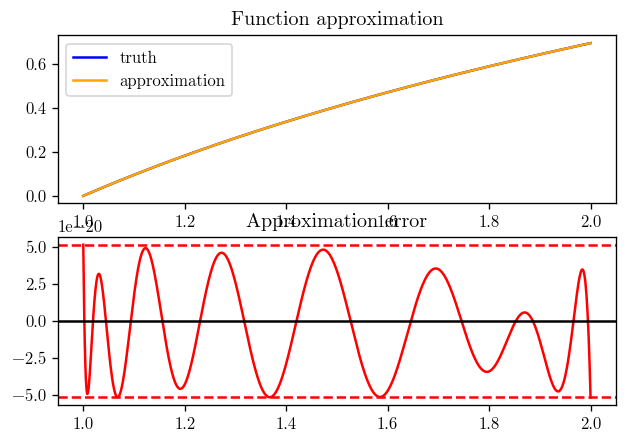

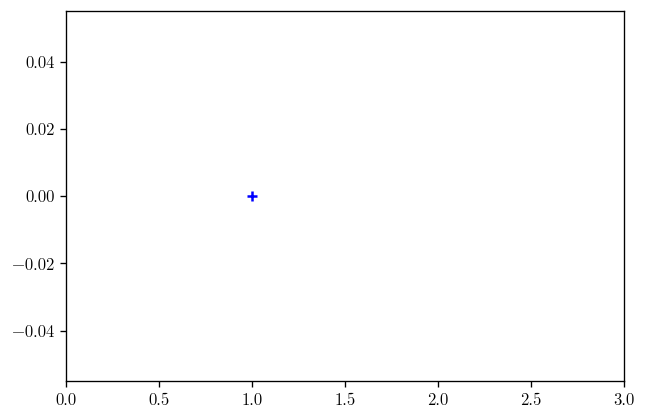

In [277]:
plt.close('all')

display(x)

p, q, h = rat_fit(8, 8, x, y)
plot(h)
plot_roots(p, q)

In [268]:
plt.close('all')

p1, q1, h1 = remez_iter(p, q, check_poles=True)
print(f'Max error: {float(max_error(h1))}')
plot(h1)
plot_roots(p1, q1)

ZeroDivisionError: Zeros in denominator

## Export

In [343]:
mp.prec = 1024
x = [mp.mpf(x) for x in x]
y = [f(x) for x in x]
p, q, h = rat_fit(8, 8, x, y)
plot(h)
plot_roots(p, q)

ValueError: Value should be equal to n

## Remez

In [34]:
def winnow_extrema(x, y, n):
    best = None
    best_s = None
    best_score = None
    sx = x[:n]
    sy = y[:n]
    for s in itertools.combinations(range(len(x)), n):
        assert len(s) == n
        
        # Construct candidate subsequence
        for i, j in zip(range(n), s):
            sx[i] = x[j]
            sy[i] = y[j]
        
        # Test for alternating
        alternating = True
        for i in range(n - 1):
            if mp.sign(sy[i]) != -mp.sign(sy[i + 1]):
                alternating = False
                break
        if not alternating:
            continue
        
        # Score sequence
        score = (min([abs(sy) for sy in sy]), max([abs(sy) for sy in sy]))
        # print(s, f'{(float(score[0]),float(score[1]))}')
        if best_score is None or score > best_score:
            best = (sx[:], sy[:])
            best_s = s[:]
            best_score = score
    
    if best is None:
        raise Exception("No valid subsquence found")
    
    # print(best_s, f'{(float(best_score[0]),float(best_score[1]))}')
    return best

In [35]:
def remez_guess(h, n):
    # Find initial extrema by grid search.
    x = linspace(start, stop, 1000)
    yf = [f(x) for x in x]
    yh = [h(x) for x in x]
    e = [yh - yf for yf, yh in zip(yf, yh)]
    d = [n - p for n, p in zip(e[1:], e[:-1])]
    xm = [start]
    for i in range(len(d) - 1):
        if mp.sign(d[i]) != mp.sign(d[i + 1]):
            assert x[i] <= x[i + 1]
            assert x[i + 1] <= x[i + 2]
            # Refine by location
            # TODO: Fix this, doesn't seem to work. Give it a _much_ wider range
            sign =  -mp.sign(d[i])
            xr = golden_section_search(lambda x: sign * (h(x) - f(x)), x[i], x[i+2])
            #print(float(xr - x[i]))
            xm += [xr]
    xm += [stop]
    assert len(xm) >= n
    
    # Winnow
    em = [h(x) - f(x) for x in xm]
    xm, em = winnow_extrema(xm, em, n)
    
    return xm, em

In [36]:
def remez_iter(p, q, check_poles=True):
    n = len(p)
    m = len(q)
    h = ratfn(p, q)
    x, e = remez_guess(h, n + m)
    
    # Create matrix
    y = [f(x) for x in x]
    s = [mp.sign(e) for e in e]
    def try_e(e_guess):
        M = mp.matrix(n + m)
        for i in range(M.rows):
            for j in range(n):
                M[i, j] = x[i] ** j
            for j in range(m - 1):
                M[i, j + n] = - (y[i] + s[i] * e_guess) * x[i] ** (j + 1)
            M[i, n + m - 1] = - s[i]
        r = list(mp.lu_solve(M, y))
        p, q, e = r[:n], [mp.mpf(1)] + r[n:n + m - 1], r[-1]
        return p, q, e
    
    e = mp.findroot(lambda e: try_e(e)[2] - e, max([abs(e) for e in e]), verbose=False)
    p, q, er = try_e(e)
    # print(f'{float(e)} {float(er)}')

    if check_poles:
        # Make sure q has no roots in the domain
        for root in mp.polyroots(list(reversed(q))):
            # Real roots in the domain
            if type(root) == mp.mpf and root >= start and root <= stop:
                raise ZeroDivisionError("Zeros in denominator")
    
    h = ratfn(p, q)
    return p, q, h

In [43]:
def approx(n, m, r=5, plots=False):
    p, q, h = rational(n, m)
    print(f'Max error: {float(max_error(h))}')
    if plots:
        plot(h)
        plot_roots(p, q)
    for i in range(r):
        p, q, h = remez_iter(p, q)
        print(f'Max error: {float(max_error(h))}')
        if plots:
            plot(h)
            plot_roots(p, q)
    return p, q, h

In [39]:
# Use medium precision to find the number of coefficients
mp.prec = 256
num_parameters = 15

for j in range(num_parameters):
    n = num_parameters - j
    m = 1 + num_parameters - n
    print(f'\nOptimizing ({n}, {m})')
    try:
        p, q, h = approx(n, m, 5)
    except Exception as e:
        print(f'({n}, {m}) failed: {e}')


Optimizing (15, 1)
Max error: 3.614874375153855e-12
Max error: 9.666420085153815e-13
Max error: 5.371374857497887e-13
Max error: 4.543235308372754e-13
Max error: 4.4983800005874117e-13
Max error: 4.498378630000528e-13

Optimizing (14, 2)
Max error: 9.59744435110525e-15
Max error: 4.016653197348613e-15
Max error: 2.5886516613913827e-15
Max error: 2.390123356812222e-15
Max error: 2.387191231382713e-15
Max error: 2.3871913940896058e-15

Optimizing (13, 3)
Max error: 1.3241082111281323e-16
(13, 3) failed: Zeros in denominator

Optimizing (12, 4)
Max error: 6.816576776303793e-18
(12, 4) failed: Zeros in denominator

Optimizing (11, 5)
Max error: 8.977118496978843e-19
(11, 5) failed: Zeros in denominator

Optimizing (10, 6)
Max error: 2.3130240041262315e-19
(10, 6) failed: Zeros in denominator

Optimizing (9, 7)
Max error: 1.0791873583248278e-19
(9, 7) failed: Zeros in denominator

Optimizing (8, 8)
Max error: 8.399070536193643e-20
(8, 8) failed: Zeros in denominator

Optimizing (7, 9)
Max 

In [41]:
plt.close('all')

# Use very high precision to find the target rational function
mp.prec = 1000

Max error: 8.399070536193643e-20
Maximum absolute error: 8.399070536193643e-20


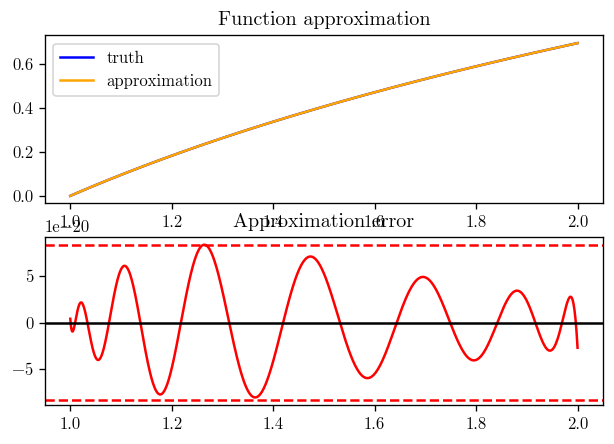

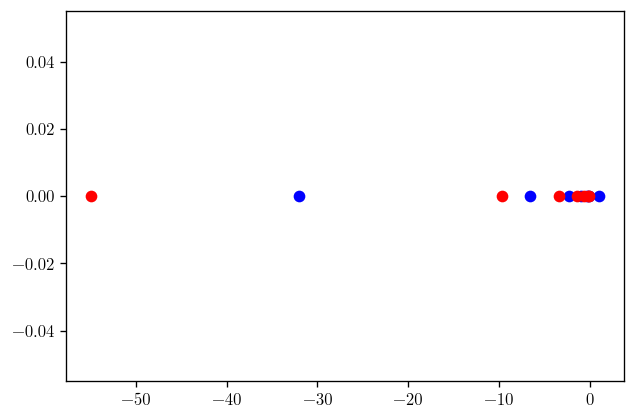

ZeroDivisionError: Zeros in denominator

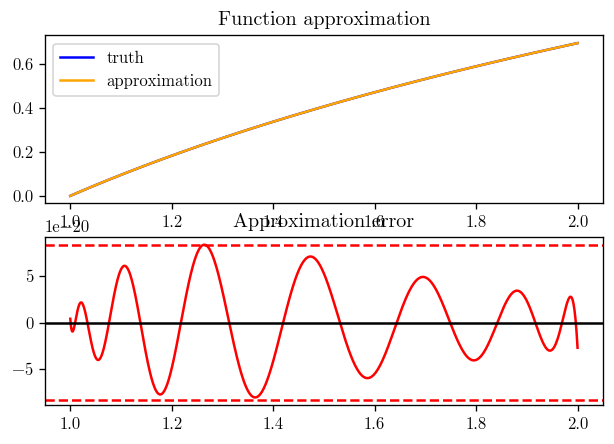

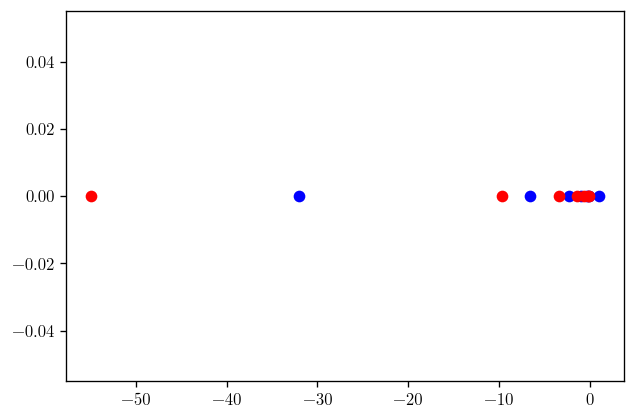

In [44]:
p, q, h = approx(8, 8, 5, plots=True)

## Export

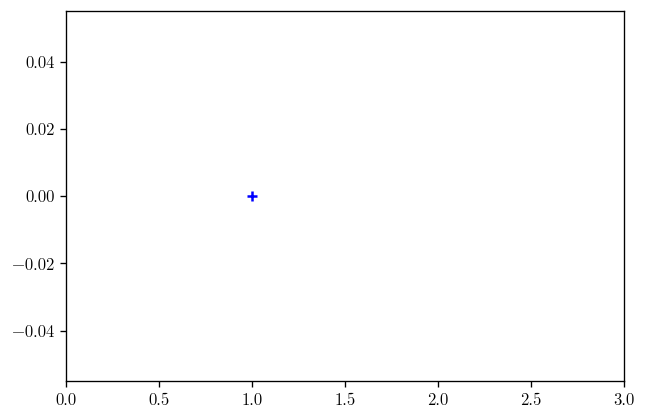

In [280]:
# Make sure the roots are not near the domain
plot_roots(p, q)

In [281]:
# Rescale so q[-1] is 1
pr = [pi / q[-1] for pi in p]
qr = [qi / q[-1] for qi in q]

In [282]:
# Factor out scale s so p[-1] is 1
ps = [pi / pr[-1] for pi in pr]
s = pr[-1]

In [289]:
# Print closest representable numbers
def represent(x, base = 2**96):
    n = int(mp.nint(x * base))
    #if n < 0:
    #    n += 2**256
    # assert n >= 0 and n < 2**256
    return n

for i, pi in enumerate(reversed(ps)):
    print(f'p{len(pr) - i - 1} = {represent(pi)} // {float(pi)}')
print()

for i, qi in enumerate(reversed(qr)):
    print(f'q{len(qr) - i - 1} = {represent(qi)} // {float(qi)}')
print()

print(f's = {represent(s)} // {float(s)}')


print(f'ln2 = {represent(mp.log(2))} // {float(mp.log(2))}')


p7 = 79228162514264337593543950336 // 1.0
p6 = 3273285459638523848632254066296 // 41.314670891795544
p5 = 24828157081833163892658089445524 // 313.37539952871015
p4 = 43456485725739037958740375743393 // 548.4979626772877
p3 = -11111509109440967052023855526967 // -140.24696215112192
p2 = -45023709667254063763336534515857 // -568.279109832289
p1 = -14706773417378608786704636184526 // -185.62557745461766
p0 = -795164235651350426258249787498 // -10.036383659764772

q7 = 79228162514264337593543950336 // 1.0
q6 = 5573035233440673466300451813936 // 70.34159390528964
q5 = 71694874799317883764090561454958 // 904.9165413423522
q4 = 283447036172924575727196451306956 // 3577.6045686013786
q3 = 401686690394027663651624208769553 // 5069.99881919144
q2 = 204048457590392012362485061816622 // 2575.453615419326
q1 = 31853899698501571402653359427138 // 402.0527384156682
q0 = 909429971244387300277376558375 // 11.478620005615458

s = 439668470185123797622540459591 // 5.549396278197987
ln2 = 5491677746770747

In [369]:
mpf(1267650600228229401496703205376000000000000000000) / 2**96

mpf('16000000000000000000.0')

In [365]:
hex(50216813883093446110686315385661331328818843555712276103168000000000000000000)

'0x6f05b59d3b200000000000000000000000000000000000000000000000000000'

In [359]:
represent(s * mpf(5**18), base = 2**96)

1677202110996718588342820967067443963516166

In [361]:
represent(mp.ln(2), base = 5**18 * 2**192)

16597577552685614221487285958193947469193820559219878177908093499208371

In [360]:
represent(mp.ln(2**96) - mp.ln(10**18), base = 5**18 * 2**192)

600920179829731861736702779321621459595472258049074101567377883020018308

In [371]:
255 - 96

159

In [347]:
mp.log(mpf(2**96) / 5**18) / mp.log(2)

mpf('54.2052942920274777383342502691909768344330349255575489830143848753131740210447461146974846195313372082061673092154954671171662542832565160110445500860242029106648756521648997644256830345795519499950541992677857437646272480251144035842767745861954787550459656082109341010501345959197570959204244869055172958243')

In [333]:
mp.ln(23945242826029513411849172299223580994042798784118784000000000000000000) / mp.ln(2)

mpf('233.7947057079725222616657497308090231655669650744424510169856151246868259789552538853025153804686627917938326907845045328828337457167434839889554499139757970893351243478351002355743169654204480500049458007322142562353727519748855964157232254138045212449540343917890658989498654040802429040795755130944827041753')

In [337]:
s

mpf('5.549396278197987182524497255078820576338342831690933279720457706338816329566020750482098373319745744145469276169928671419748747153929380380721105366278908231418069397786683034727555487684766361391212167802923308091191647519931991181554072300855691329008584940060799519526342082525105560710429715810032766701129')

In [299]:
f(137438953472000000000000000000 / 2**96)

mpf('0.5508480208560490567071510182861382203653188680628535754797816573060832779803564235020133988240668051773327325474820171139257644617608187550655982973085886567794030709860695789602828280625888387148054387548714198282111229054037882575761137854784717825121823022111541666251857523168965228381970334172064381106002')

In [335]:
f(start) / s, f(stop) / s

(mpf('0.0'),
 mpf('0.1249049708854141639924754012766721295277315123694600742346435344811152873903238606598834698725743491169866455475109395208216282757603365770672405040046258789995397002550143847956168278336268415775449380518177353027146713818536319164736632162824118173135823683554016926866733835119330684839803486895610299261283'))

In [336]:
s

mpf('5.549396278197987182524497255078820576338342831690933279720457706338816329566020750482098373319745744145469276169928671419748747153929380380721105366278908231418069397786683034727555487684766361391212167802923308091191647519931991181554072300855691329008584940060799519526342082525105560710429715810032766701129')

In [284]:
for i in reversed(range(6)):
    e = -2**i
    print(f'{e}, {represent(e)}, {represent(mp.exp(mp.mpf(e)))}')

-32, -2535301200456458802993406410752, 1003358566231181
-16, -1267650600228229401496703205376, 8915955111228592727647
-8, -633825300114114700748351602688, 26578087600922394298733672
-4, -316912650057057350374175801344, 1451114414429211511965335629
-2, -158456325028528675187087900672, 10722365814184344471345157570
-1, -79228162514264337593543950336, 29146412150787779157341161347


In [285]:
def eval_poly(c, x):
    r = c[-1]
    for c in reversed(c[:-1]):
        # print(represent(r))
        r = r * x + c
    return r

In [286]:
def range_reduce(x):
    k = mp.nint(x / mp.log(2))
    k = mp.floor(x / mp.log(2) + 0.5)
    r = x - k * mp.log(2)
    assert r >= start and r <= stop
    return r, k

In [287]:
x = linspace(-42, 135, 10000)
#x = linspace(-5, 5, 10000)
r = [range_reduce(x)[0] for x in x]
k = [range_reduce(x)[1] for x in x]

AssertionError: 

In [288]:
plt.plot(x, r)
plt.axhline(start, color='red')
plt.axhline(stop, color='red')

NameError: name 'r' is not defined

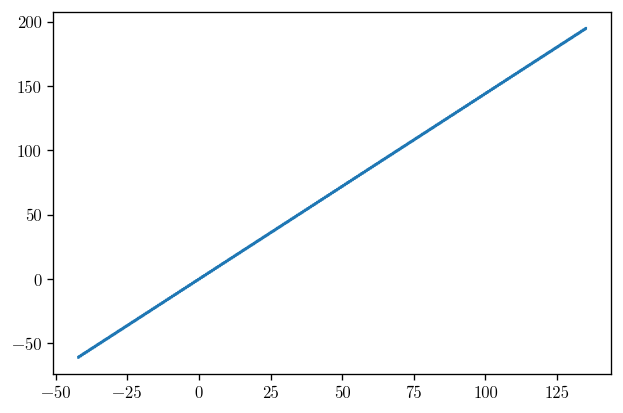

In [1178]:
plt.plot(x, k)

In [1180]:
mp.exp(start), mp.exp(stop)

(mpf('0.7071067811865475244008443621048490392845'),
 mpf('1.414213562373095048801688724209698078569'))

In [1181]:
96 + 196

292

In [1187]:
mp.log(1.5 * 3814697265625 * 2**96) / mp.log(2)

mpf('138.37966820869367844311948867475683967475')

In [1188]:
256 - 139

117

In [1197]:
mp.floor(mp.log((mp.mpf(2**255) - 1) / 1e18) * 1e18)

mpf('135305999368893231589.0')

In [1198]:
mp.exp(mp.mpf(135305999368893231589) / 1e18) * 1e18 / 2**255

mpf('0.99999999999999999992965521248353087781244')

In [1199]:
57896044618658097649809650851135836446708721278684416180224000000000000000000 / 1e18

5.78960446186581e+58

In [1201]:
mp.exp(mp.mpf(135305999368893231588) / 1e18) - 57896044618658097649809650851135836446708721278684416180224000000000000000000 / 1e18

mpf('-4.2039921047687509331676632734967562690888e+42')

In [1202]:
117 + 78

195

In [1203]:
5**18 / 2**78

1.2621774483536189e-11

In [1204]:
1104 - 721

383

In [1205]:
1604 - 1104

500

In [1206]:
135305999368893231589 / 1e18

135.30599936889323

In [1207]:
1557 - 1101

456

In [1208]:
2013 - 1557

456

In [1209]:
477854134370404556630342282363 / 2**96

6.031367120048645

In [1227]:
477854134370404556630342282363 * 5**18 * 2**21

3822833074963236453042738258904000000000000000000

In [1229]:
represent(s * 5**18 * 2**21)

3822833074963236453042738258902158003155416615667

In [1230]:
s

mpf('6.03136712004864557952315856198929863614111669874514109730927255939775680189403952220316710517480306071594208850188477877556735820804525198969457536138443146380669185671847293556187249609011898065568851103702548955022119646024320050108034707536267030603063224450764720753103001093975039398009916225723977')

In [1232]:
0.6/s

mpf('0.0994799334972600239893273185070413787335074214738769293354171471956504620526585596986367195163103066279063471406432600230139165007154885810944805265755928220115956940694648139148085763573446950911250314328520382288861688733867882069978923174639892733131962725623587603272123912668129074972485196665840986')

In [1233]:
1.5/s

mpf('0.248699833743150069177061017670724671979300081715420282379222122103761857021323047513692562854944835063364612722940710747049408285683428782806373677021051744300103997446415559994572078918575189480671293215950075778368215245360934589842409783703087414428790748992287034492163707583561787648342743108696308')

In [1235]:
117 + 78

195

In [1237]:
mp.log(2**96)/mp.log(10)

mpf('28.898879583742194740518933893551330569746228620362419965801036268202386170344752910745016203345872515905709810377375556393097716588818256575970464035650775206192284568402566655534694493913882576113654678225143931246826195058745188449972931153942973841562796403878425278009083661969201342555136577662302')

In [1238]:
2**96

79228162514264337593543950336

In [31]:
mp.log(1000000000000000000) / mp.log(2)

mpf('59.7947057079725222616657497308090231655669650744424510169856151246868259789552538853025153804686627917938326907845045328828337457167434839889554499139757970893351243478351002355743169654204480500049458007322142562353727519748855964157232254138045212449540343917890658989498654040802429040795755130944786')

In [33]:
mp.log(68719476736000000000000000000) / mp.log(2)

mpf('95.7947057079725222616657497308090231655669650744424510169856151246868259789552538853025153804686627917938326907845045328828337457167434839889554499139757970893351243478351002355743169654204480500049458007322142562353727519748855964157232254138045212449540343917890658989498654040802429040795755130944845')

In [1240]:
-146734746076776222436 / 1e18

-146.73474607677622

In [1241]:
11723370297369374509729453784 / 2**96

0.14796973608038283

In [1244]:
2**7 * mp.exp(11723370297369374509729453784 / 2**96)

mpf('148.413159102576602797754083563570111419653820541465285237666042237698759889625988360891040035965826369113610383319083172246154719918203608319123322448591962360409021343976357096610477205469832985887818694692235881954573458875421906196628354792740184032576721445531220311788045498028288403446882565129333')

In [1245]:
15230924295686815968900942473 / 2**96

0.19224129163597126

In [1246]:
15230924295686815968900942473 * 3822833074963236453042738258902158003155416615667

58225281159812697126805713314171885814935114840302346943497197419720317524491

In [1250]:
(15230924295686815968900942473 * 3822833074963236453042738258902158003155416615667) / 2**255

1.0056866845278147

In [1252]:
3822833074963236453042738258902158003155416615667 // 2

1911416537481618226521369129451079001577708307833

In [1253]:
116+78

194

In [27]:
int(mp.nint(mp.ln(mp.mpf(2)) * 1e18))

693147180559945309

## Knuth explicit formula for 7-term polynomial q

In [1370]:
def alpha(u, root=0):
    b = [mp.mpf(0)] * 9
    b[1] = (u[5] - 1) / 2
    b[2] = u[4] - b[1] * (b[1] + 1)
    b[3] = u[3] - b[1] * b[2]
    b[4] = b[1] - b[2]
    b[5] = u[2] - b[1] * b[3]
    
    coeff = [
        u[1] - b[2] * b[5],
        2 * b[5] - b[2] * b[4] - b[3],
        2 * b[4] - b[2] + 1,
        mp.mpf(2)
    ]
    roots = mp.polyroots(list(reversed(coeff)), extraprec=100)
    b[6] = roots[root]
    
    b[7] = b[6]**2 + b[4] * b[6] + b[5]
    b[8] = b[3] - b[6] - b[7]
    
    a = [mp.mpf(0)] * 6
    a[0] = b[2] - 2 * b[6]
    a[2] = b[1] - a[0]
    a[1] = b[6] - a[0] * a[2]
    a[3] = b[7] - a[1] * a[2]
    a[4] = b[8] - b[7] - a[1]
    a[5] = u[0] - b[7] * b[8]
    
    return a

In [1387]:
def eval_knuth(a, x):
    print(represent(x))
    z = (x + a[0]) * x + a[1]
    print(represent(z))
    w = (x + a[2]) * z + a[3]
    print(represent(w))
    u = (w + z + a[4]) * w + a[5]
    print(represent(u))
    return u

In [1372]:
# Knuth's example
alpha([mp.mpf(x) for x in [3, -37, -61, 33, 49, 13, 1]], root=1)

[mpf('3.0'), mpf('-7.0'), mpf('3.0'), mpf('16.0'), mpf('6.0'), mpf('-27.0')]

In [1373]:
qa = alpha(qr)

In [1378]:
eval_knuth(qa, mp.mpf(10)), eval_poly(qr, mp.mpf(10))

(mpf('33940.6392633364003325682591863775752607548877694584357065028225429751234565231771220428887816390463416994077120539647912124225385434116695253366237435058847193515463230847933866955218820567536849495829302960016402308551515883219623186213748494548049886280056620274733344589220135990908085013749346953869'),
 mpf('33940.6392633364003325682591863775752607548877694584357065028225429751234565231771220428887816390463416994077120539647912124225385434116695253366237435058847193515463230847933866955218820567536849495829302960016402308551515883219623186213748494548049886280056620274733344589220135990908085013749346889159'))

In [1382]:
for i, a in enumerate(qa):
    print(f'a_{i} = {represent(a)}')

a_0 = 750530180792738023273180420736
a_1 = 32788456221302202726307501949080
a_2 = -2218138959503481824038194425854
a_3 = 892943633302991980437332862907700
a_4 = -78174809823045304726920794422040
a_5 = 4203224763890128580604056984195872


In [1383]:
11723370297369374509729453784 / 2**96

0.14796973608038283

In [1388]:
eval_knuth(qa, mp.mpf(11723370297369374509729453784) / 2**96)

11723370297369374509729453784
32901246678083340530892776720321
-23319236756237536982852715105152
24392153673876097338736908011219514


mpf('307872.26283942283081356436585799304102856979866890668051525407211139128660650124887064136171073507966899399398135838310755818738128061657025265193688008271190170541298988519713659845201578120010817090581585382791830342758783910117444637093487394783394331765935207670303334666592305150294633472007635673')

## Knuth explicit formula for 6-term polynomial p

In [1393]:
ps

[mpf('55349.9208146512037099932492742768790032776866251732540539497786874794377327112267517246827759200494752549050144458012707920185168382286789810324801386514069587346104233796686258561533005832633490305972435238257173068725863661308933689512369319183511951864098950282543769151713292891737820109792425445717'),
 mpf('25165.7965601770841639097143382802041702991350645376057038734792704624136972006971124896753649347501815815465126835316186027005678801158323009278269868797444906593306535322367063600018654071487392795978487429768428224013657119591286721833937329734496209792922889736227787273609870086241373195619552688043'),
 mpf('5034.68059751714501309988364383253130384035249143361105637187523836579152614503995586614205992893866693147512721854604804179935916529615137423100137401094654816477541970938404486369174706884028512253270916493022984293568857166778626262797641391247159576650042453151568632094809705436807888865386628111719'),
 mpf('559.597591603183149093896172209858109506097565111846

In [1409]:
def alpha(u):
    u0 = u[0]
    u = u[1:]
    
    a = [mp.mpf(0)] * 5
    a[0] = (u[3] - 1) / 2
    b = u[2] - a[0] * (a[0] + 1)
    a[1] = u[1] - a[0] * b
    a[2] = b - 2 * a[1]
    a[3] = u[0] - a[1] * (a[1] + a[2])
    a[4] = u0
    
    return a

In [1414]:
def eval_knuth(a, x):
    y = (x + a[0]) * x + a[1]
    u = y + x + a[2]
    u = u * y + a[3]
    u = u * x + a[4]
    return u

In [1415]:
pa = alpha(ps)

In [1416]:
for i, a in enumerate(pa):
    print(f'a_{i} = {represent(a)}')

a_0 = 1346386616545796478920950773328
a_1 = 57155421227552351082224309758442
a_2 = -94201549194550492254356042504812
a_3 = 28719021644029726153956944680412240
a_4 = 4385272521454847904632057985693276


In [1417]:
eval_knuth(pa, mp.mpf(10)), eval_poly(ps, mp.mpf(10))

(mpf('1819949.30260516683854093327338562245401478053020435462193654361555063609192284055008224936262172481465961871467154129946029162762259821955700911182340414572046974084739161891912515302617220540048445938433545534287657380914906529807479736034621723507962722308891659624673147432660806842825071514824674783'),
 mpf('1819949.30260516683854093327338562245401478053020435462193654361555063609192284055008224936262172481465961871467154129946029162762259821955700911182340414572046974084739161891912515302617220540048445938433545534287657380914906529807479736034621723507962722308891659624673147432660806842825071514824674724'))